### PSF Investigation

In [1]:
# Imports
from astropy.table import Table
import lsst.daf.butler as dafButler
import glob
import lsst.afw.table as afwTable
import matplotlib as mpl
import matplotlib.pyplot as plt
from modelling_research.plotting import plotjoint_running_percentiles
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [2]:
# Config
hsc = True
overwrite = False
gen2to3 = True
filter_inexact_psf = True
filter_interpolated = True
midfix = '_gen2to3' if gen2to3 else ''
savepre = (f'/project/dtaranu/{"hsc" if hsc else "dc2_gen3"}'
           f'/coaddpsf/w_202{"1_02" if hsc else "0_48"}{midfix}/')
if not os.path.isdir(savepre):
    os.mkdir(savepre)
savepost = '.parq'
bands = ['g', 'r', 'i']
if hsc:
    butler = dafButler.Butler('/repo/main', collections='HSC/runs/RC2/w_2021_02/DM-28282')
    n_patches = 81
    scale_pix = 0.168
    tracts = [9615, 9697]
    # It's pointless to include COSMOS if these flags are used as 90%+ of coadd stars have them
    if not filter_inexact_psf and not filter_interpolated:
        tracts.append(9813)
    limxs = {band: x for band, x in zip(bands, ((0.525, 1.275), (0.35, 1.0), (0.35, 1.0),))}
    limsfrac = (-0.05, 0.05)
else:
    butler = dafButler.Butler('/repo/dc2', collections='2.2i/runs/test-med-1/w_2020_48/DM-27780')
    tracts = [3828, 3829]
    n_patches = 49
    scale_pix = 0.2
    filter_inexact_psf = True
    filter_interpolated = True
    limxs = {band: x for band, x in zip(bands, ((0.6, 1.2), (0.65, 0.95), (0.65, 0.95),))}
    limsfrac = (-0.025, 0.025)
patches = list(range(n_patches))

In [3]:
# Plot settings
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['figure.figsize'] = 10, 20
sns.set(rc={'axes.facecolor': '0.85', 'figure.facecolor': 'w'})
sns.set_style('dark')

In [4]:
# Take a sourceCatalog and turn it into a condensed parquet table
def make_summary(butler, type_cat=None, **kwargs):
    if type_cat is None:
        type_cat = 'deepCoadd_meas'
    try:
        src = butler.get(type_cat, **kwargs)
    except Exception as e:
        print(f'Failed to butler.get({type_cat}, {kwargs}) due to {e}')
        return None

    mask = src['calib_psf_used']
    n_psf = np.sum(mask)
    stars = src[mask]
    
    mask = None
    flags = [
        'base_PixelFlags_flag_clipped',
        'base_PixelFlags_flag_saturated',
    ]
    if filter_inexact_psf:
        flags.append('base_PixelFlags_flag_inexact_psf')
    if filter_interpolated:
        flags.append('base_PixelFlags_flag_interpolated')
    for flag in flags:
        if mask is None:
            mask = ~stars[flag]
        else:
            mask = mask & ~stars[flag]
        print(f'Flag {flag} filters {np.sum(stars[flag])}/{n_psf} for dataId: {kwargs}')
    print(f'Selected {np.sum(mask)}/{n_psf}')
    if np.sum(mask)==0:
        print('No data')
        return None
    stars = stars[mask]
    starIxx = stars['base_SdssShape_xx']
    starIxy = stars['base_SdssShape_xy']
    starIyy = stars['base_SdssShape_yy']
    modelIxx = stars['base_SdssShape_psf_xx']
    modelIxy = stars['base_SdssShape_psf_xy']
    modelIyy = stars['base_SdssShape_psf_yy']
    data = {}
    data['starE1'] = (starIxx-starIyy)/(starIxx+starIyy)
    data['starE2'] = (2*starIxy)/(starIxx+starIyy)
    data['starSize'] = np.sqrt(0.5*(starIxx + starIyy))*2.354820045*scale_pix
    data['modelE1'] = (modelIxx-modelIyy)/(modelIxx+modelIyy)
    data['modelE2'] = (2*modelIxy)/(modelIxx+modelIyy)
    data['modelSize'] = np.sqrt(0.5*(modelIxx + modelIyy))*2.354820045*scale_pix
    data['ra'] = [a.getCoord().getRa().asDegrees() for a in stars]
    data['dec'] = [a.getCoord().getDec().asDegrees() for a in stars]
    data['fluxPsf'] = stars['base_PsfFlux_instFlux']
    data['fluxPsfErr'] = stars['base_PsfFlux_instFluxErr']
    data['fluxCmodel'] = stars['modelfit_CModel_instFlux']
    data['fluxCmodelErr'] = stars['modelfit_CModel_instFluxErr']
    df = pd.DataFrame(data)
    return df

def make_table(band, tracts, patches, **kwargs):
    data=[]
    for tract in tracts:
        for patch in patches:
            print(f'Making summary for band={band}, tract={tract}, patch={patch}')
            result = make_summary(band=band, tract=tract, patch=patch, **kwargs)
            if result is None:
                continue
            data.append(result)
    table = pd.concat(data)
    return table

In [5]:
# Read/write data
data = {}
for band in bands:
    desc = (f'{",".join((str(x) for x in tracts))}_{band}_filt_inexact'
            f'{int(filter_inexact_psf)}_interp{int(filter_interpolated)}')
    savefile = f'{savepre}{desc}{savepost}'
    if overwrite or not os.path.exists(savefile):
        print(f'Generating {savefile} for band={band}, tracts={tracts}, patches={patches}')
        table = make_table(band, tracts, patches, butler=butler)
        table.to_parquet(savefile)
        data[band] = table
    else:
        print(f'Reading {savefile}')
        data[band] = pd.read_parquet(savefile)

Generating /project/dtaranu/hsc/coaddpsf/w_2021_02_gen2to3/9615,9697_g_filt_inexact1_interp1.parq for band=g, tracts=[9615, 9697], patches=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
Making summary for band=g, tract=9615, patch=0
Flag base_PixelFlags_flag_clipped filters 22/431 for dataId: {'band': 'g', 'tract': 9615, 'patch': 0}
Flag base_PixelFlags_flag_saturated filters 6/431 for dataId: {'band': 'g', 'tract': 9615, 'patch': 0}
Flag base_PixelFlags_flag_inexact_psf filters 164/431 for dataId: {'band': 'g', 'tract': 9615, 'patch': 0}
Flag base_PixelFlags_flag_interpolated filters 58/431 for dataId: {'band': 'g', 'tract': 9615, 'patch': 0}
Selected 241/431
Making summary for band=g, tract=9615, patch=1
Flag base_PixelF

Flag base_PixelFlags_flag_clipped filters 22/441 for dataId: {'band': 'g', 'tract': 9615, 'patch': 16}
Flag base_PixelFlags_flag_saturated filters 2/441 for dataId: {'band': 'g', 'tract': 9615, 'patch': 16}
Flag base_PixelFlags_flag_inexact_psf filters 128/441 for dataId: {'band': 'g', 'tract': 9615, 'patch': 16}
Flag base_PixelFlags_flag_interpolated filters 60/441 for dataId: {'band': 'g', 'tract': 9615, 'patch': 16}
Selected 270/441
Making summary for band=g, tract=9615, patch=17
Flag base_PixelFlags_flag_clipped filters 11/413 for dataId: {'band': 'g', 'tract': 9615, 'patch': 17}
Flag base_PixelFlags_flag_saturated filters 5/413 for dataId: {'band': 'g', 'tract': 9615, 'patch': 17}
Flag base_PixelFlags_flag_inexact_psf filters 152/413 for dataId: {'band': 'g', 'tract': 9615, 'patch': 17}
Flag base_PixelFlags_flag_interpolated filters 50/413 for dataId: {'band': 'g', 'tract': 9615, 'patch': 17}
Selected 237/413
Making summary for band=g, tract=9615, patch=18
Flag base_PixelFlags_fla

Flag base_PixelFlags_flag_clipped filters 12/429 for dataId: {'band': 'g', 'tract': 9615, 'patch': 33}
Flag base_PixelFlags_flag_saturated filters 3/429 for dataId: {'band': 'g', 'tract': 9615, 'patch': 33}
Flag base_PixelFlags_flag_inexact_psf filters 156/429 for dataId: {'band': 'g', 'tract': 9615, 'patch': 33}
Flag base_PixelFlags_flag_interpolated filters 69/429 for dataId: {'band': 'g', 'tract': 9615, 'patch': 33}
Selected 231/429
Making summary for band=g, tract=9615, patch=34
Flag base_PixelFlags_flag_clipped filters 9/358 for dataId: {'band': 'g', 'tract': 9615, 'patch': 34}
Flag base_PixelFlags_flag_saturated filters 3/358 for dataId: {'band': 'g', 'tract': 9615, 'patch': 34}
Flag base_PixelFlags_flag_inexact_psf filters 120/358 for dataId: {'band': 'g', 'tract': 9615, 'patch': 34}
Flag base_PixelFlags_flag_interpolated filters 45/358 for dataId: {'band': 'g', 'tract': 9615, 'patch': 34}
Selected 210/358
Making summary for band=g, tract=9615, patch=35
Flag base_PixelFlags_flag

Flag base_PixelFlags_flag_clipped filters 13/445 for dataId: {'band': 'g', 'tract': 9615, 'patch': 50}
Flag base_PixelFlags_flag_saturated filters 7/445 for dataId: {'band': 'g', 'tract': 9615, 'patch': 50}
Flag base_PixelFlags_flag_inexact_psf filters 162/445 for dataId: {'band': 'g', 'tract': 9615, 'patch': 50}
Flag base_PixelFlags_flag_interpolated filters 64/445 for dataId: {'band': 'g', 'tract': 9615, 'patch': 50}
Selected 250/445
Making summary for band=g, tract=9615, patch=51
Flag base_PixelFlags_flag_clipped filters 20/385 for dataId: {'band': 'g', 'tract': 9615, 'patch': 51}
Flag base_PixelFlags_flag_saturated filters 0/385 for dataId: {'band': 'g', 'tract': 9615, 'patch': 51}
Flag base_PixelFlags_flag_inexact_psf filters 102/385 for dataId: {'band': 'g', 'tract': 9615, 'patch': 51}
Flag base_PixelFlags_flag_interpolated filters 28/385 for dataId: {'band': 'g', 'tract': 9615, 'patch': 51}
Selected 263/385
Making summary for band=g, tract=9615, patch=52
Flag base_PixelFlags_fla

Flag base_PixelFlags_flag_clipped filters 20/368 for dataId: {'band': 'g', 'tract': 9615, 'patch': 67}
Flag base_PixelFlags_flag_saturated filters 8/368 for dataId: {'band': 'g', 'tract': 9615, 'patch': 67}
Flag base_PixelFlags_flag_inexact_psf filters 97/368 for dataId: {'band': 'g', 'tract': 9615, 'patch': 67}
Flag base_PixelFlags_flag_interpolated filters 51/368 for dataId: {'band': 'g', 'tract': 9615, 'patch': 67}
Selected 235/368
Making summary for band=g, tract=9615, patch=68
Flag base_PixelFlags_flag_clipped filters 4/380 for dataId: {'band': 'g', 'tract': 9615, 'patch': 68}
Flag base_PixelFlags_flag_saturated filters 11/380 for dataId: {'band': 'g', 'tract': 9615, 'patch': 68}
Flag base_PixelFlags_flag_inexact_psf filters 100/380 for dataId: {'band': 'g', 'tract': 9615, 'patch': 68}
Flag base_PixelFlags_flag_interpolated filters 25/380 for dataId: {'band': 'g', 'tract': 9615, 'patch': 68}
Selected 263/380
Making summary for band=g, tract=9615, patch=69
Flag base_PixelFlags_flag

Flag base_PixelFlags_flag_clipped filters 27/271 for dataId: {'band': 'g', 'tract': 9697, 'patch': 3}
Flag base_PixelFlags_flag_saturated filters 4/271 for dataId: {'band': 'g', 'tract': 9697, 'patch': 3}
Flag base_PixelFlags_flag_inexact_psf filters 104/271 for dataId: {'band': 'g', 'tract': 9697, 'patch': 3}
Flag base_PixelFlags_flag_interpolated filters 30/271 for dataId: {'band': 'g', 'tract': 9697, 'patch': 3}
Selected 148/271
Making summary for band=g, tract=9697, patch=4
Flag base_PixelFlags_flag_clipped filters 13/298 for dataId: {'band': 'g', 'tract': 9697, 'patch': 4}
Flag base_PixelFlags_flag_saturated filters 4/298 for dataId: {'band': 'g', 'tract': 9697, 'patch': 4}
Flag base_PixelFlags_flag_inexact_psf filters 135/298 for dataId: {'band': 'g', 'tract': 9697, 'patch': 4}
Flag base_PixelFlags_flag_interpolated filters 60/298 for dataId: {'band': 'g', 'tract': 9697, 'patch': 4}
Selected 142/298
Making summary for band=g, tract=9697, patch=5
Flag base_PixelFlags_flag_clipped 

Flag base_PixelFlags_flag_clipped filters 36/290 for dataId: {'band': 'g', 'tract': 9697, 'patch': 20}
Flag base_PixelFlags_flag_saturated filters 6/290 for dataId: {'band': 'g', 'tract': 9697, 'patch': 20}
Flag base_PixelFlags_flag_inexact_psf filters 119/290 for dataId: {'band': 'g', 'tract': 9697, 'patch': 20}
Flag base_PixelFlags_flag_interpolated filters 53/290 for dataId: {'band': 'g', 'tract': 9697, 'patch': 20}
Selected 146/290
Making summary for band=g, tract=9697, patch=21
Flag base_PixelFlags_flag_clipped filters 31/277 for dataId: {'band': 'g', 'tract': 9697, 'patch': 21}
Flag base_PixelFlags_flag_saturated filters 5/277 for dataId: {'band': 'g', 'tract': 9697, 'patch': 21}
Flag base_PixelFlags_flag_inexact_psf filters 112/277 for dataId: {'band': 'g', 'tract': 9697, 'patch': 21}
Flag base_PixelFlags_flag_interpolated filters 40/277 for dataId: {'band': 'g', 'tract': 9697, 'patch': 21}
Selected 139/277
Making summary for band=g, tract=9697, patch=22
Flag base_PixelFlags_fla

Flag base_PixelFlags_flag_clipped filters 15/317 for dataId: {'band': 'g', 'tract': 9697, 'patch': 37}
Flag base_PixelFlags_flag_saturated filters 2/317 for dataId: {'band': 'g', 'tract': 9697, 'patch': 37}
Flag base_PixelFlags_flag_inexact_psf filters 131/317 for dataId: {'band': 'g', 'tract': 9697, 'patch': 37}
Flag base_PixelFlags_flag_interpolated filters 44/317 for dataId: {'band': 'g', 'tract': 9697, 'patch': 37}
Selected 161/317
Making summary for band=g, tract=9697, patch=38
Flag base_PixelFlags_flag_clipped filters 8/280 for dataId: {'band': 'g', 'tract': 9697, 'patch': 38}
Flag base_PixelFlags_flag_saturated filters 1/280 for dataId: {'band': 'g', 'tract': 9697, 'patch': 38}
Flag base_PixelFlags_flag_inexact_psf filters 116/280 for dataId: {'band': 'g', 'tract': 9697, 'patch': 38}
Flag base_PixelFlags_flag_interpolated filters 50/280 for dataId: {'band': 'g', 'tract': 9697, 'patch': 38}
Selected 137/280
Making summary for band=g, tract=9697, patch=39
Flag base_PixelFlags_flag

Flag base_PixelFlags_flag_clipped filters 3/229 for dataId: {'band': 'g', 'tract': 9697, 'patch': 54}
Flag base_PixelFlags_flag_saturated filters 5/229 for dataId: {'band': 'g', 'tract': 9697, 'patch': 54}
Flag base_PixelFlags_flag_inexact_psf filters 94/229 for dataId: {'band': 'g', 'tract': 9697, 'patch': 54}
Flag base_PixelFlags_flag_interpolated filters 33/229 for dataId: {'band': 'g', 'tract': 9697, 'patch': 54}
Selected 117/229
Making summary for band=g, tract=9697, patch=55
Flag base_PixelFlags_flag_clipped filters 8/203 for dataId: {'band': 'g', 'tract': 9697, 'patch': 55}
Flag base_PixelFlags_flag_saturated filters 9/203 for dataId: {'band': 'g', 'tract': 9697, 'patch': 55}
Flag base_PixelFlags_flag_inexact_psf filters 123/203 for dataId: {'band': 'g', 'tract': 9697, 'patch': 55}
Flag base_PixelFlags_flag_interpolated filters 62/203 for dataId: {'band': 'g', 'tract': 9697, 'patch': 55}
Selected 52/203
Making summary for band=g, tract=9697, patch=56
Flag base_PixelFlags_flag_cl

Flag base_PixelFlags_flag_clipped filters 17/296 for dataId: {'band': 'g', 'tract': 9697, 'patch': 71}
Flag base_PixelFlags_flag_saturated filters 4/296 for dataId: {'band': 'g', 'tract': 9697, 'patch': 71}
Flag base_PixelFlags_flag_inexact_psf filters 179/296 for dataId: {'band': 'g', 'tract': 9697, 'patch': 71}
Flag base_PixelFlags_flag_interpolated filters 74/296 for dataId: {'band': 'g', 'tract': 9697, 'patch': 71}
Selected 93/296
Making summary for band=g, tract=9697, patch=72
Flag base_PixelFlags_flag_clipped filters 9/271 for dataId: {'band': 'g', 'tract': 9697, 'patch': 72}
Flag base_PixelFlags_flag_saturated filters 6/271 for dataId: {'band': 'g', 'tract': 9697, 'patch': 72}
Flag base_PixelFlags_flag_inexact_psf filters 94/271 for dataId: {'band': 'g', 'tract': 9697, 'patch': 72}
Flag base_PixelFlags_flag_interpolated filters 43/271 for dataId: {'band': 'g', 'tract': 9697, 'patch': 72}
Selected 156/271
Making summary for band=g, tract=9697, patch=73
Flag base_PixelFlags_flag_c

Flag base_PixelFlags_flag_clipped filters 146/537 for dataId: {'band': 'r', 'tract': 9615, 'patch': 6}
Flag base_PixelFlags_flag_saturated filters 26/537 for dataId: {'band': 'r', 'tract': 9615, 'patch': 6}
Flag base_PixelFlags_flag_inexact_psf filters 255/537 for dataId: {'band': 'r', 'tract': 9615, 'patch': 6}
Flag base_PixelFlags_flag_interpolated filters 49/537 for dataId: {'band': 'r', 'tract': 9615, 'patch': 6}
Selected 257/537
Making summary for band=r, tract=9615, patch=7
Flag base_PixelFlags_flag_clipped filters 123/600 for dataId: {'band': 'r', 'tract': 9615, 'patch': 7}
Flag base_PixelFlags_flag_saturated filters 17/600 for dataId: {'band': 'r', 'tract': 9615, 'patch': 7}
Flag base_PixelFlags_flag_inexact_psf filters 263/600 for dataId: {'band': 'r', 'tract': 9615, 'patch': 7}
Flag base_PixelFlags_flag_interpolated filters 54/600 for dataId: {'band': 'r', 'tract': 9615, 'patch': 7}
Selected 322/600
Making summary for band=r, tract=9615, patch=8
Flag base_PixelFlags_flag_clip

Flag base_PixelFlags_flag_clipped filters 83/548 for dataId: {'band': 'r', 'tract': 9615, 'patch': 23}
Flag base_PixelFlags_flag_saturated filters 13/548 for dataId: {'band': 'r', 'tract': 9615, 'patch': 23}
Flag base_PixelFlags_flag_inexact_psf filters 241/548 for dataId: {'band': 'r', 'tract': 9615, 'patch': 23}
Flag base_PixelFlags_flag_interpolated filters 76/548 for dataId: {'band': 'r', 'tract': 9615, 'patch': 23}
Selected 263/548
Making summary for band=r, tract=9615, patch=24
Flag base_PixelFlags_flag_clipped filters 155/593 for dataId: {'band': 'r', 'tract': 9615, 'patch': 24}
Flag base_PixelFlags_flag_saturated filters 21/593 for dataId: {'band': 'r', 'tract': 9615, 'patch': 24}
Flag base_PixelFlags_flag_inexact_psf filters 322/593 for dataId: {'band': 'r', 'tract': 9615, 'patch': 24}
Flag base_PixelFlags_flag_interpolated filters 94/593 for dataId: {'band': 'r', 'tract': 9615, 'patch': 24}
Selected 231/593
Making summary for band=r, tract=9615, patch=25
Flag base_PixelFlags_

Flag base_PixelFlags_flag_clipped filters 99/600 for dataId: {'band': 'r', 'tract': 9615, 'patch': 40}
Flag base_PixelFlags_flag_saturated filters 36/600 for dataId: {'band': 'r', 'tract': 9615, 'patch': 40}
Flag base_PixelFlags_flag_inexact_psf filters 271/600 for dataId: {'band': 'r', 'tract': 9615, 'patch': 40}
Flag base_PixelFlags_flag_interpolated filters 81/600 for dataId: {'band': 'r', 'tract': 9615, 'patch': 40}
Selected 294/600
Making summary for band=r, tract=9615, patch=41
Flag base_PixelFlags_flag_clipped filters 40/552 for dataId: {'band': 'r', 'tract': 9615, 'patch': 41}
Flag base_PixelFlags_flag_saturated filters 15/552 for dataId: {'band': 'r', 'tract': 9615, 'patch': 41}
Flag base_PixelFlags_flag_inexact_psf filters 158/552 for dataId: {'band': 'r', 'tract': 9615, 'patch': 41}
Flag base_PixelFlags_flag_interpolated filters 51/552 for dataId: {'band': 'r', 'tract': 9615, 'patch': 41}
Selected 368/552
Making summary for band=r, tract=9615, patch=42
Flag base_PixelFlags_f

Flag base_PixelFlags_flag_clipped filters 109/607 for dataId: {'band': 'r', 'tract': 9615, 'patch': 57}
Flag base_PixelFlags_flag_saturated filters 15/607 for dataId: {'band': 'r', 'tract': 9615, 'patch': 57}
Flag base_PixelFlags_flag_inexact_psf filters 206/607 for dataId: {'band': 'r', 'tract': 9615, 'patch': 57}
Flag base_PixelFlags_flag_interpolated filters 52/607 for dataId: {'band': 'r', 'tract': 9615, 'patch': 57}
Selected 374/607
Making summary for band=r, tract=9615, patch=58
Flag base_PixelFlags_flag_clipped filters 88/548 for dataId: {'band': 'r', 'tract': 9615, 'patch': 58}
Flag base_PixelFlags_flag_saturated filters 17/548 for dataId: {'band': 'r', 'tract': 9615, 'patch': 58}
Flag base_PixelFlags_flag_inexact_psf filters 202/548 for dataId: {'band': 'r', 'tract': 9615, 'patch': 58}
Flag base_PixelFlags_flag_interpolated filters 60/548 for dataId: {'band': 'r', 'tract': 9615, 'patch': 58}
Selected 313/548
Making summary for band=r, tract=9615, patch=59
Flag base_PixelFlags_

Flag base_PixelFlags_flag_clipped filters 22/489 for dataId: {'band': 'r', 'tract': 9615, 'patch': 74}
Flag base_PixelFlags_flag_saturated filters 21/489 for dataId: {'band': 'r', 'tract': 9615, 'patch': 74}
Flag base_PixelFlags_flag_inexact_psf filters 129/489 for dataId: {'band': 'r', 'tract': 9615, 'patch': 74}
Flag base_PixelFlags_flag_interpolated filters 38/489 for dataId: {'band': 'r', 'tract': 9615, 'patch': 74}
Selected 335/489
Making summary for band=r, tract=9615, patch=75
Flag base_PixelFlags_flag_clipped filters 90/572 for dataId: {'band': 'r', 'tract': 9615, 'patch': 75}
Flag base_PixelFlags_flag_saturated filters 17/572 for dataId: {'band': 'r', 'tract': 9615, 'patch': 75}
Flag base_PixelFlags_flag_inexact_psf filters 201/572 for dataId: {'band': 'r', 'tract': 9615, 'patch': 75}
Flag base_PixelFlags_flag_interpolated filters 39/572 for dataId: {'band': 'r', 'tract': 9615, 'patch': 75}
Selected 356/572
Making summary for band=r, tract=9615, patch=76
Flag base_PixelFlags_f

Flag base_PixelFlags_flag_clipped filters 61/376 for dataId: {'band': 'r', 'tract': 9697, 'patch': 10}
Flag base_PixelFlags_flag_saturated filters 32/376 for dataId: {'band': 'r', 'tract': 9697, 'patch': 10}
Flag base_PixelFlags_flag_inexact_psf filters 218/376 for dataId: {'band': 'r', 'tract': 9697, 'patch': 10}
Flag base_PixelFlags_flag_interpolated filters 82/376 for dataId: {'band': 'r', 'tract': 9697, 'patch': 10}
Selected 132/376
Making summary for band=r, tract=9697, patch=11
Flag base_PixelFlags_flag_clipped filters 74/394 for dataId: {'band': 'r', 'tract': 9697, 'patch': 11}
Flag base_PixelFlags_flag_saturated filters 12/394 for dataId: {'band': 'r', 'tract': 9697, 'patch': 11}
Flag base_PixelFlags_flag_inexact_psf filters 190/394 for dataId: {'band': 'r', 'tract': 9697, 'patch': 11}
Flag base_PixelFlags_flag_interpolated filters 79/394 for dataId: {'band': 'r', 'tract': 9697, 'patch': 11}
Selected 168/394
Making summary for band=r, tract=9697, patch=12
Flag base_PixelFlags_f

Flag base_PixelFlags_flag_clipped filters 51/411 for dataId: {'band': 'r', 'tract': 9697, 'patch': 27}
Flag base_PixelFlags_flag_saturated filters 19/411 for dataId: {'band': 'r', 'tract': 9697, 'patch': 27}
Flag base_PixelFlags_flag_inexact_psf filters 172/411 for dataId: {'band': 'r', 'tract': 9697, 'patch': 27}
Flag base_PixelFlags_flag_interpolated filters 65/411 for dataId: {'band': 'r', 'tract': 9697, 'patch': 27}
Selected 208/411
Making summary for band=r, tract=9697, patch=28
Flag base_PixelFlags_flag_clipped filters 53/385 for dataId: {'band': 'r', 'tract': 9697, 'patch': 28}
Flag base_PixelFlags_flag_saturated filters 4/385 for dataId: {'band': 'r', 'tract': 9697, 'patch': 28}
Flag base_PixelFlags_flag_inexact_psf filters 148/385 for dataId: {'band': 'r', 'tract': 9697, 'patch': 28}
Flag base_PixelFlags_flag_interpolated filters 39/385 for dataId: {'band': 'r', 'tract': 9697, 'patch': 28}
Selected 218/385
Making summary for band=r, tract=9697, patch=29
Flag base_PixelFlags_fl

Flag base_PixelFlags_flag_clipped filters 40/459 for dataId: {'band': 'r', 'tract': 9697, 'patch': 44}
Flag base_PixelFlags_flag_saturated filters 3/459 for dataId: {'band': 'r', 'tract': 9697, 'patch': 44}
Flag base_PixelFlags_flag_inexact_psf filters 142/459 for dataId: {'band': 'r', 'tract': 9697, 'patch': 44}
Flag base_PixelFlags_flag_interpolated filters 52/459 for dataId: {'band': 'r', 'tract': 9697, 'patch': 44}
Selected 285/459
Making summary for band=r, tract=9697, patch=45
Flag base_PixelFlags_flag_clipped filters 16/420 for dataId: {'band': 'r', 'tract': 9697, 'patch': 45}
Flag base_PixelFlags_flag_saturated filters 13/420 for dataId: {'band': 'r', 'tract': 9697, 'patch': 45}
Flag base_PixelFlags_flag_inexact_psf filters 147/420 for dataId: {'band': 'r', 'tract': 9697, 'patch': 45}
Flag base_PixelFlags_flag_interpolated filters 47/420 for dataId: {'band': 'r', 'tract': 9697, 'patch': 45}
Selected 246/420
Making summary for band=r, tract=9697, patch=46
Flag base_PixelFlags_fl

Flag base_PixelFlags_flag_clipped filters 36/450 for dataId: {'band': 'r', 'tract': 9697, 'patch': 61}
Flag base_PixelFlags_flag_saturated filters 10/450 for dataId: {'band': 'r', 'tract': 9697, 'patch': 61}
Flag base_PixelFlags_flag_inexact_psf filters 187/450 for dataId: {'band': 'r', 'tract': 9697, 'patch': 61}
Flag base_PixelFlags_flag_interpolated filters 59/450 for dataId: {'band': 'r', 'tract': 9697, 'patch': 61}
Selected 241/450
Making summary for band=r, tract=9697, patch=62
Flag base_PixelFlags_flag_clipped filters 60/449 for dataId: {'band': 'r', 'tract': 9697, 'patch': 62}
Flag base_PixelFlags_flag_saturated filters 6/449 for dataId: {'band': 'r', 'tract': 9697, 'patch': 62}
Flag base_PixelFlags_flag_inexact_psf filters 262/449 for dataId: {'band': 'r', 'tract': 9697, 'patch': 62}
Flag base_PixelFlags_flag_interpolated filters 77/449 for dataId: {'band': 'r', 'tract': 9697, 'patch': 62}
Selected 151/449
Making summary for band=r, tract=9697, patch=63
Flag base_PixelFlags_fl

Flag base_PixelFlags_flag_clipped filters 39/444 for dataId: {'band': 'r', 'tract': 9697, 'patch': 78}
Flag base_PixelFlags_flag_saturated filters 3/444 for dataId: {'band': 'r', 'tract': 9697, 'patch': 78}
Flag base_PixelFlags_flag_inexact_psf filters 173/444 for dataId: {'band': 'r', 'tract': 9697, 'patch': 78}
Flag base_PixelFlags_flag_interpolated filters 74/444 for dataId: {'band': 'r', 'tract': 9697, 'patch': 78}
Selected 230/444
Making summary for band=r, tract=9697, patch=79
Flag base_PixelFlags_flag_clipped filters 24/454 for dataId: {'band': 'r', 'tract': 9697, 'patch': 79}
Flag base_PixelFlags_flag_saturated filters 6/454 for dataId: {'band': 'r', 'tract': 9697, 'patch': 79}
Flag base_PixelFlags_flag_inexact_psf filters 139/454 for dataId: {'band': 'r', 'tract': 9697, 'patch': 79}
Flag base_PixelFlags_flag_interpolated filters 55/454 for dataId: {'band': 'r', 'tract': 9697, 'patch': 79}
Selected 283/454
Making summary for band=r, tract=9697, patch=80
Flag base_PixelFlags_fla

Flag base_PixelFlags_flag_clipped filters 93/655 for dataId: {'band': 'i', 'tract': 9615, 'patch': 13}
Flag base_PixelFlags_flag_saturated filters 38/655 for dataId: {'band': 'i', 'tract': 9615, 'patch': 13}
Flag base_PixelFlags_flag_inexact_psf filters 285/655 for dataId: {'band': 'i', 'tract': 9615, 'patch': 13}
Flag base_PixelFlags_flag_interpolated filters 137/655 for dataId: {'band': 'i', 'tract': 9615, 'patch': 13}
Selected 307/655
Making summary for band=i, tract=9615, patch=14
Flag base_PixelFlags_flag_clipped filters 109/646 for dataId: {'band': 'i', 'tract': 9615, 'patch': 14}
Flag base_PixelFlags_flag_saturated filters 55/646 for dataId: {'band': 'i', 'tract': 9615, 'patch': 14}
Flag base_PixelFlags_flag_inexact_psf filters 340/646 for dataId: {'band': 'i', 'tract': 9615, 'patch': 14}
Flag base_PixelFlags_flag_interpolated filters 142/646 for dataId: {'band': 'i', 'tract': 9615, 'patch': 14}
Selected 245/646
Making summary for band=i, tract=9615, patch=15
Flag base_PixelFlag

Flag base_PixelFlags_flag_clipped filters 73/699 for dataId: {'band': 'i', 'tract': 9615, 'patch': 30}
Flag base_PixelFlags_flag_saturated filters 25/699 for dataId: {'band': 'i', 'tract': 9615, 'patch': 30}
Flag base_PixelFlags_flag_inexact_psf filters 400/699 for dataId: {'band': 'i', 'tract': 9615, 'patch': 30}
Flag base_PixelFlags_flag_interpolated filters 135/699 for dataId: {'band': 'i', 'tract': 9615, 'patch': 30}
Selected 247/699
Making summary for band=i, tract=9615, patch=31
Flag base_PixelFlags_flag_clipped filters 58/624 for dataId: {'band': 'i', 'tract': 9615, 'patch': 31}
Flag base_PixelFlags_flag_saturated filters 36/624 for dataId: {'band': 'i', 'tract': 9615, 'patch': 31}
Flag base_PixelFlags_flag_inexact_psf filters 323/624 for dataId: {'band': 'i', 'tract': 9615, 'patch': 31}
Flag base_PixelFlags_flag_interpolated filters 137/624 for dataId: {'band': 'i', 'tract': 9615, 'patch': 31}
Selected 235/624
Making summary for band=i, tract=9615, patch=32
Flag base_PixelFlags

Flag base_PixelFlags_flag_clipped filters 143/574 for dataId: {'band': 'i', 'tract': 9615, 'patch': 47}
Flag base_PixelFlags_flag_saturated filters 53/574 for dataId: {'band': 'i', 'tract': 9615, 'patch': 47}
Flag base_PixelFlags_flag_inexact_psf filters 322/574 for dataId: {'band': 'i', 'tract': 9615, 'patch': 47}
Flag base_PixelFlags_flag_interpolated filters 128/574 for dataId: {'band': 'i', 'tract': 9615, 'patch': 47}
Selected 207/574
Making summary for band=i, tract=9615, patch=48
Flag base_PixelFlags_flag_clipped filters 174/573 for dataId: {'band': 'i', 'tract': 9615, 'patch': 48}
Flag base_PixelFlags_flag_saturated filters 76/573 for dataId: {'band': 'i', 'tract': 9615, 'patch': 48}
Flag base_PixelFlags_flag_inexact_psf filters 349/573 for dataId: {'band': 'i', 'tract': 9615, 'patch': 48}
Flag base_PixelFlags_flag_interpolated filters 129/573 for dataId: {'band': 'i', 'tract': 9615, 'patch': 48}
Selected 178/573
Making summary for band=i, tract=9615, patch=49
Flag base_PixelFla

Flag base_PixelFlags_flag_clipped filters 113/610 for dataId: {'band': 'i', 'tract': 9615, 'patch': 64}
Flag base_PixelFlags_flag_saturated filters 45/610 for dataId: {'band': 'i', 'tract': 9615, 'patch': 64}
Flag base_PixelFlags_flag_inexact_psf filters 282/610 for dataId: {'band': 'i', 'tract': 9615, 'patch': 64}
Flag base_PixelFlags_flag_interpolated filters 105/610 for dataId: {'band': 'i', 'tract': 9615, 'patch': 64}
Selected 289/610
Making summary for band=i, tract=9615, patch=65
Flag base_PixelFlags_flag_clipped filters 110/609 for dataId: {'band': 'i', 'tract': 9615, 'patch': 65}
Flag base_PixelFlags_flag_saturated filters 32/609 for dataId: {'band': 'i', 'tract': 9615, 'patch': 65}
Flag base_PixelFlags_flag_inexact_psf filters 249/609 for dataId: {'band': 'i', 'tract': 9615, 'patch': 65}
Flag base_PixelFlags_flag_interpolated filters 78/609 for dataId: {'band': 'i', 'tract': 9615, 'patch': 65}
Selected 320/609
Making summary for band=i, tract=9615, patch=66
Flag base_PixelFlag

Flag base_PixelFlags_flag_clipped filters 74/488 for dataId: {'band': 'i', 'tract': 9697, 'patch': 0}
Flag base_PixelFlags_flag_saturated filters 32/488 for dataId: {'band': 'i', 'tract': 9697, 'patch': 0}
Flag base_PixelFlags_flag_inexact_psf filters 224/488 for dataId: {'band': 'i', 'tract': 9697, 'patch': 0}
Flag base_PixelFlags_flag_interpolated filters 74/488 for dataId: {'band': 'i', 'tract': 9697, 'patch': 0}
Selected 221/488
Making summary for band=i, tract=9697, patch=1
Flag base_PixelFlags_flag_clipped filters 144/551 for dataId: {'band': 'i', 'tract': 9697, 'patch': 1}
Flag base_PixelFlags_flag_saturated filters 44/551 for dataId: {'band': 'i', 'tract': 9697, 'patch': 1}
Flag base_PixelFlags_flag_inexact_psf filters 302/551 for dataId: {'band': 'i', 'tract': 9697, 'patch': 1}
Flag base_PixelFlags_flag_interpolated filters 79/551 for dataId: {'band': 'i', 'tract': 9697, 'patch': 1}
Selected 220/551
Making summary for band=i, tract=9697, patch=2
Flag base_PixelFlags_flag_clipp

Flag base_PixelFlags_flag_clipped filters 208/502 for dataId: {'band': 'i', 'tract': 9697, 'patch': 17}
Flag base_PixelFlags_flag_saturated filters 47/502 for dataId: {'band': 'i', 'tract': 9697, 'patch': 17}
Flag base_PixelFlags_flag_inexact_psf filters 339/502 for dataId: {'band': 'i', 'tract': 9697, 'patch': 17}
Flag base_PixelFlags_flag_interpolated filters 101/502 for dataId: {'band': 'i', 'tract': 9697, 'patch': 17}
Selected 133/502
Making summary for band=i, tract=9697, patch=18
Flag base_PixelFlags_flag_clipped filters 119/543 for dataId: {'band': 'i', 'tract': 9697, 'patch': 18}
Flag base_PixelFlags_flag_saturated filters 55/543 for dataId: {'band': 'i', 'tract': 9697, 'patch': 18}
Flag base_PixelFlags_flag_inexact_psf filters 292/543 for dataId: {'band': 'i', 'tract': 9697, 'patch': 18}
Flag base_PixelFlags_flag_interpolated filters 96/543 for dataId: {'band': 'i', 'tract': 9697, 'patch': 18}
Selected 220/543
Making summary for band=i, tract=9697, patch=19
Flag base_PixelFlag

Flag base_PixelFlags_flag_clipped filters 139/527 for dataId: {'band': 'i', 'tract': 9697, 'patch': 34}
Flag base_PixelFlags_flag_saturated filters 43/527 for dataId: {'band': 'i', 'tract': 9697, 'patch': 34}
Flag base_PixelFlags_flag_inexact_psf filters 266/527 for dataId: {'band': 'i', 'tract': 9697, 'patch': 34}
Flag base_PixelFlags_flag_interpolated filters 76/527 for dataId: {'band': 'i', 'tract': 9697, 'patch': 34}
Selected 240/527
Making summary for band=i, tract=9697, patch=35
Flag base_PixelFlags_flag_clipped filters 95/513 for dataId: {'band': 'i', 'tract': 9697, 'patch': 35}
Flag base_PixelFlags_flag_saturated filters 52/513 for dataId: {'band': 'i', 'tract': 9697, 'patch': 35}
Flag base_PixelFlags_flag_inexact_psf filters 257/513 for dataId: {'band': 'i', 'tract': 9697, 'patch': 35}
Flag base_PixelFlags_flag_interpolated filters 100/513 for dataId: {'band': 'i', 'tract': 9697, 'patch': 35}
Selected 215/513
Making summary for band=i, tract=9697, patch=36
Flag base_PixelFlags

Flag base_PixelFlags_flag_clipped filters 136/562 for dataId: {'band': 'i', 'tract': 9697, 'patch': 51}
Flag base_PixelFlags_flag_saturated filters 49/562 for dataId: {'band': 'i', 'tract': 9697, 'patch': 51}
Flag base_PixelFlags_flag_inexact_psf filters 317/562 for dataId: {'band': 'i', 'tract': 9697, 'patch': 51}
Flag base_PixelFlags_flag_interpolated filters 109/562 for dataId: {'band': 'i', 'tract': 9697, 'patch': 51}
Selected 201/562
Making summary for band=i, tract=9697, patch=52
Flag base_PixelFlags_flag_clipped filters 150/581 for dataId: {'band': 'i', 'tract': 9697, 'patch': 52}
Flag base_PixelFlags_flag_saturated filters 40/581 for dataId: {'band': 'i', 'tract': 9697, 'patch': 52}
Flag base_PixelFlags_flag_inexact_psf filters 311/581 for dataId: {'band': 'i', 'tract': 9697, 'patch': 52}
Flag base_PixelFlags_flag_interpolated filters 131/581 for dataId: {'band': 'i', 'tract': 9697, 'patch': 52}
Selected 220/581
Making summary for band=i, tract=9697, patch=53
Flag base_PixelFla

Flag base_PixelFlags_flag_clipped filters 96/574 for dataId: {'band': 'i', 'tract': 9697, 'patch': 68}
Flag base_PixelFlags_flag_saturated filters 39/574 for dataId: {'band': 'i', 'tract': 9697, 'patch': 68}
Flag base_PixelFlags_flag_inexact_psf filters 311/574 for dataId: {'band': 'i', 'tract': 9697, 'patch': 68}
Flag base_PixelFlags_flag_interpolated filters 98/574 for dataId: {'band': 'i', 'tract': 9697, 'patch': 68}
Selected 234/574
Making summary for band=i, tract=9697, patch=69
Flag base_PixelFlags_flag_clipped filters 77/548 for dataId: {'band': 'i', 'tract': 9697, 'patch': 69}
Flag base_PixelFlags_flag_saturated filters 48/548 for dataId: {'band': 'i', 'tract': 9697, 'patch': 69}
Flag base_PixelFlags_flag_inexact_psf filters 284/548 for dataId: {'band': 'i', 'tract': 9697, 'patch': 69}
Flag base_PixelFlags_flag_interpolated filters 131/548 for dataId: {'band': 'i', 'tract': 9697, 'patch': 69}
Selected 220/548
Making summary for band=i, tract=9697, patch=70
Flag base_PixelFlags_

g Lanczos5 PSF model residuals (N=29019)


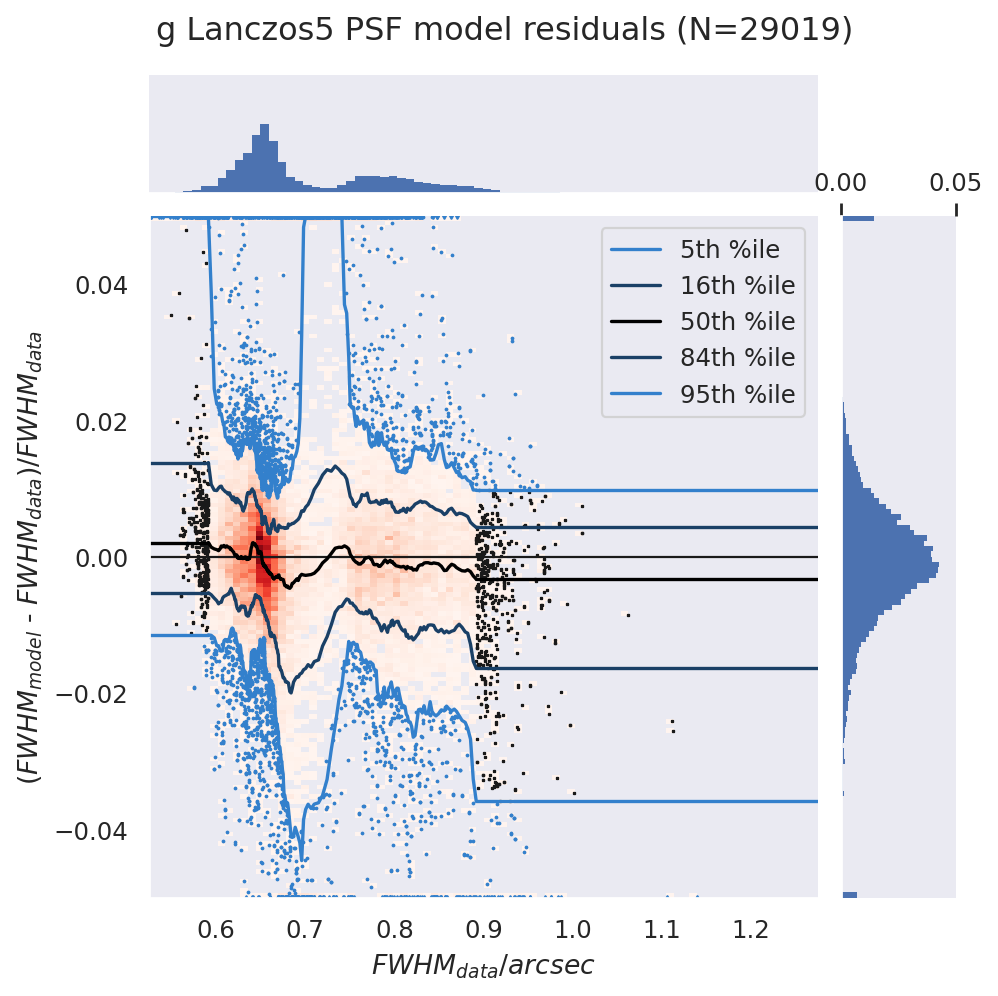

r Lanczos5 PSF model residuals (N=42233)


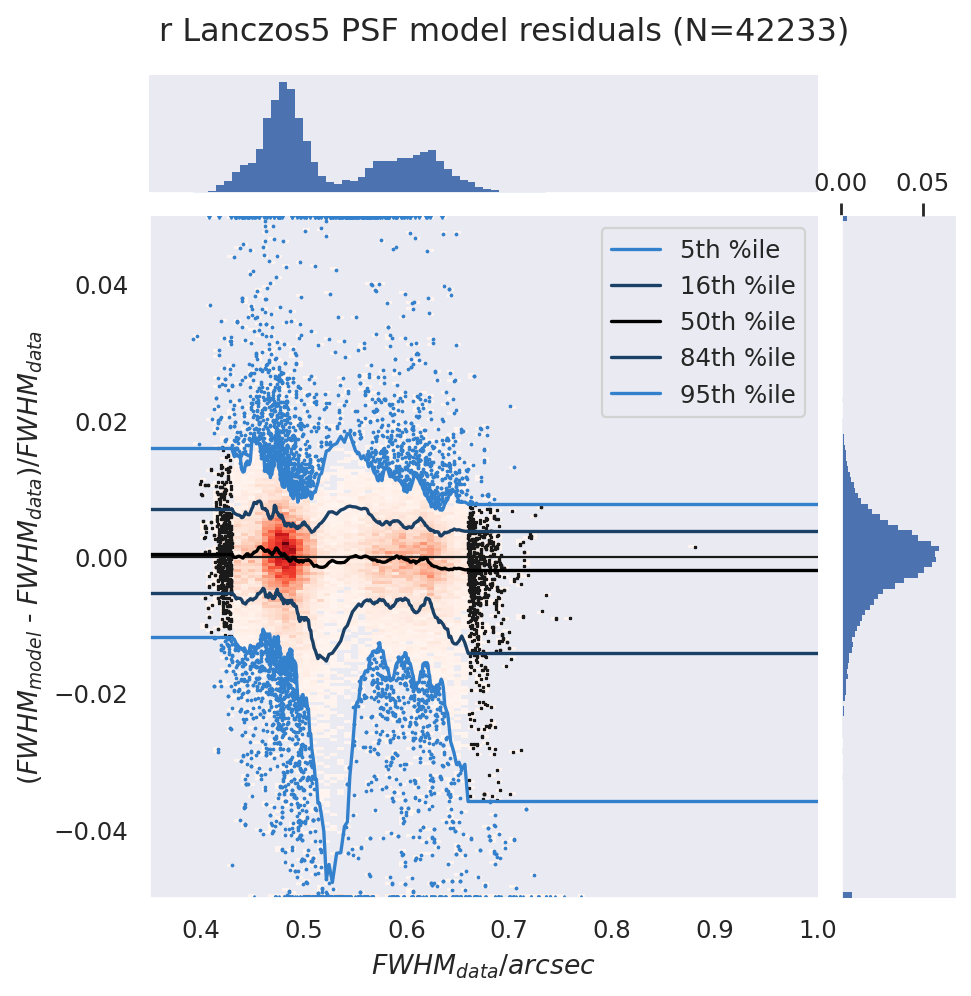

i Lanczos5 PSF model residuals (N=37137)


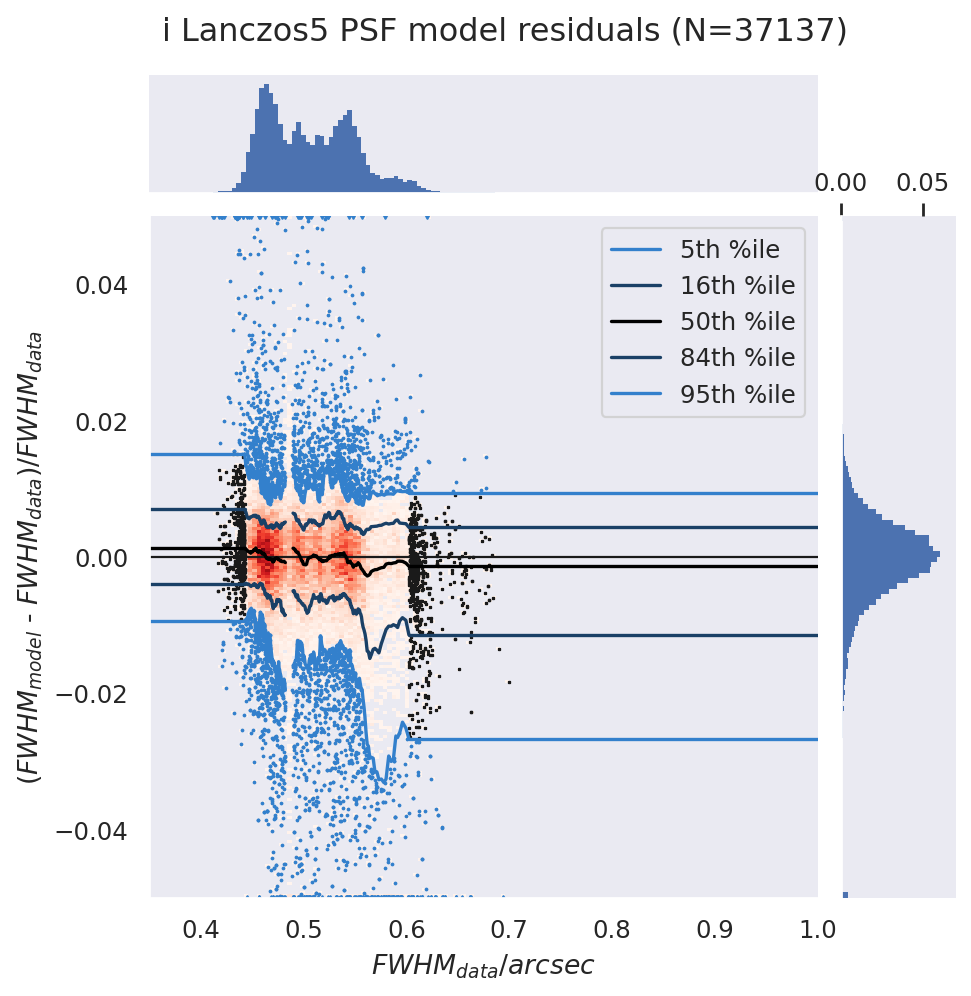

g Lanczos5, 0.515 <= FWHM <= 0.644, N=7253


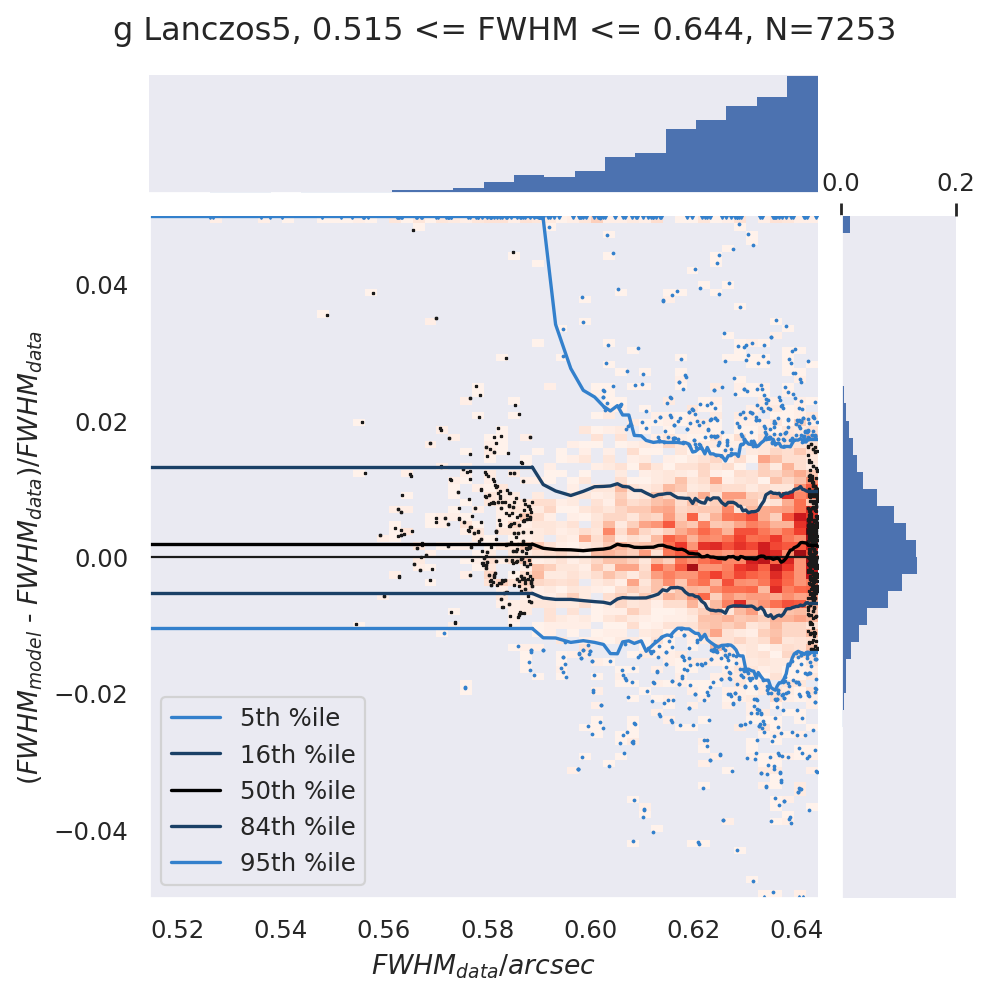

g Lanczos5, 0.644 <= FWHM <= 0.666, N=7254


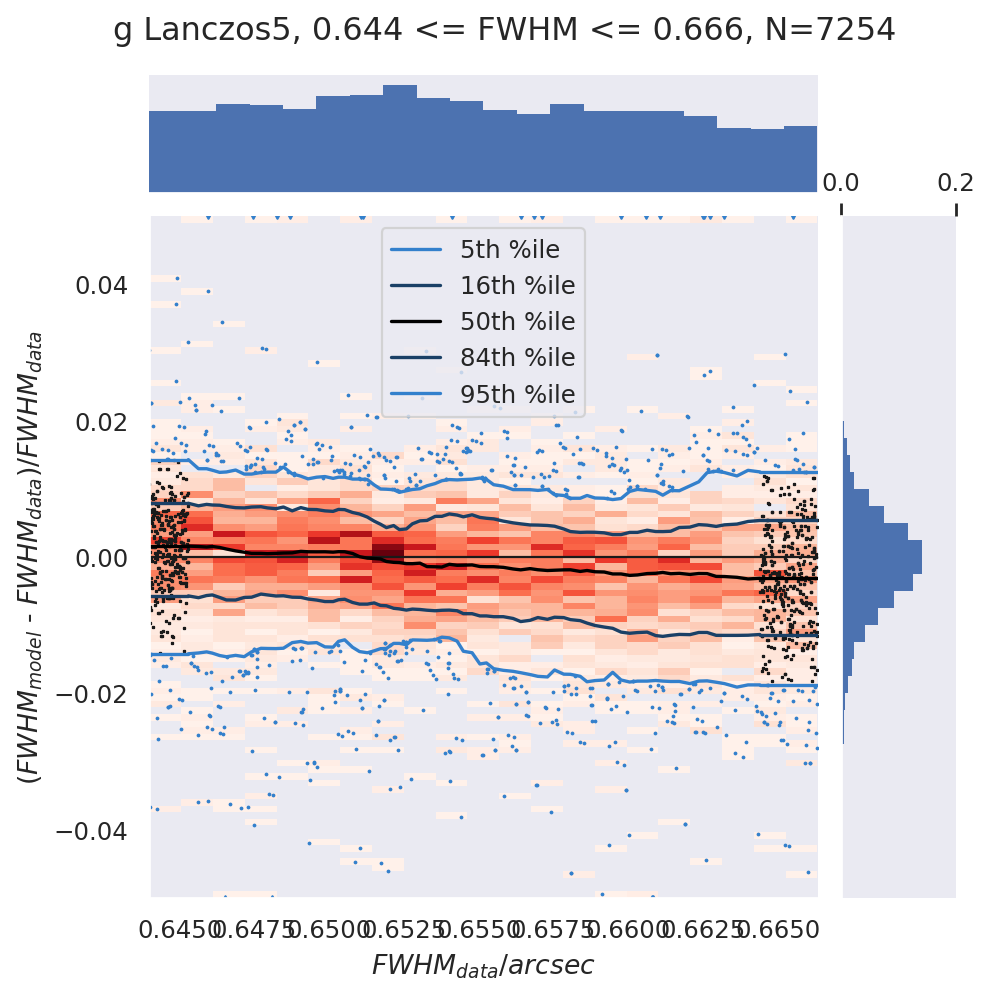

g Lanczos5, 0.666 <= FWHM <= 0.776, N=7254


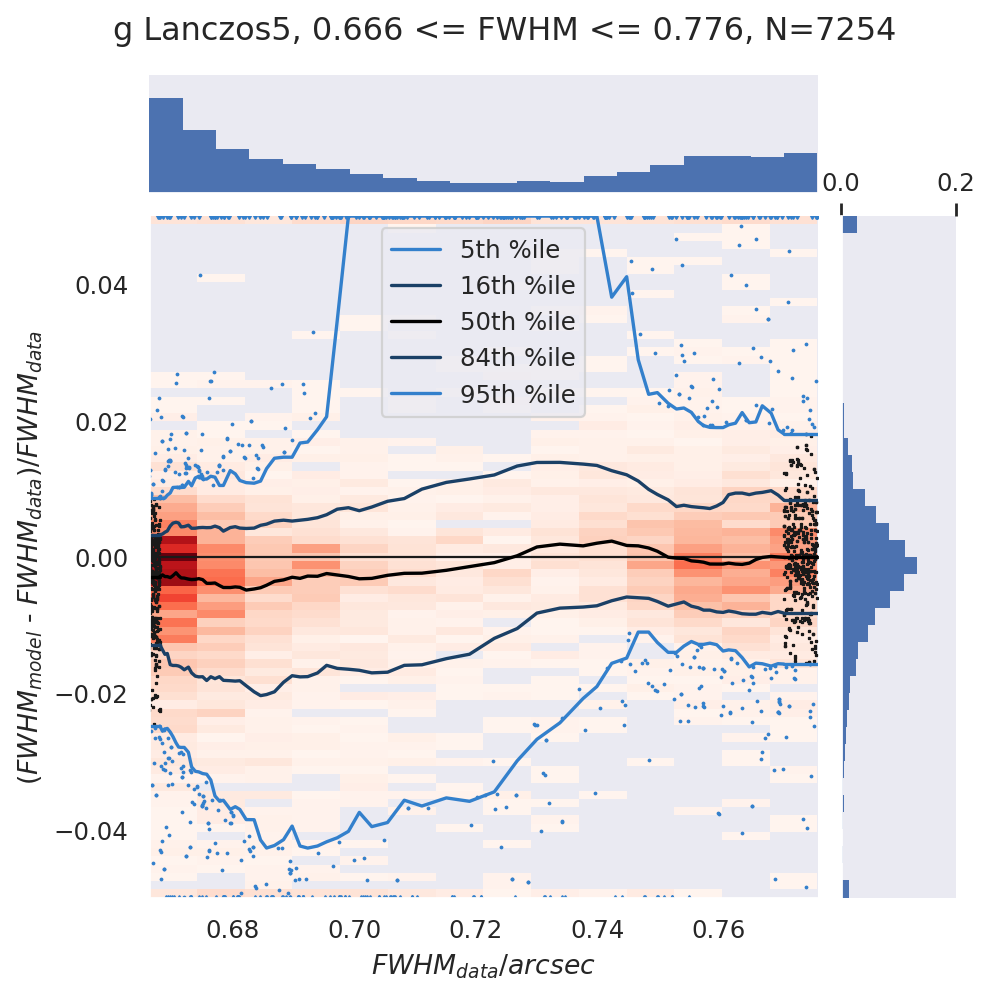

g Lanczos5, 0.776 <= FWHM <= 1.139, N=7253


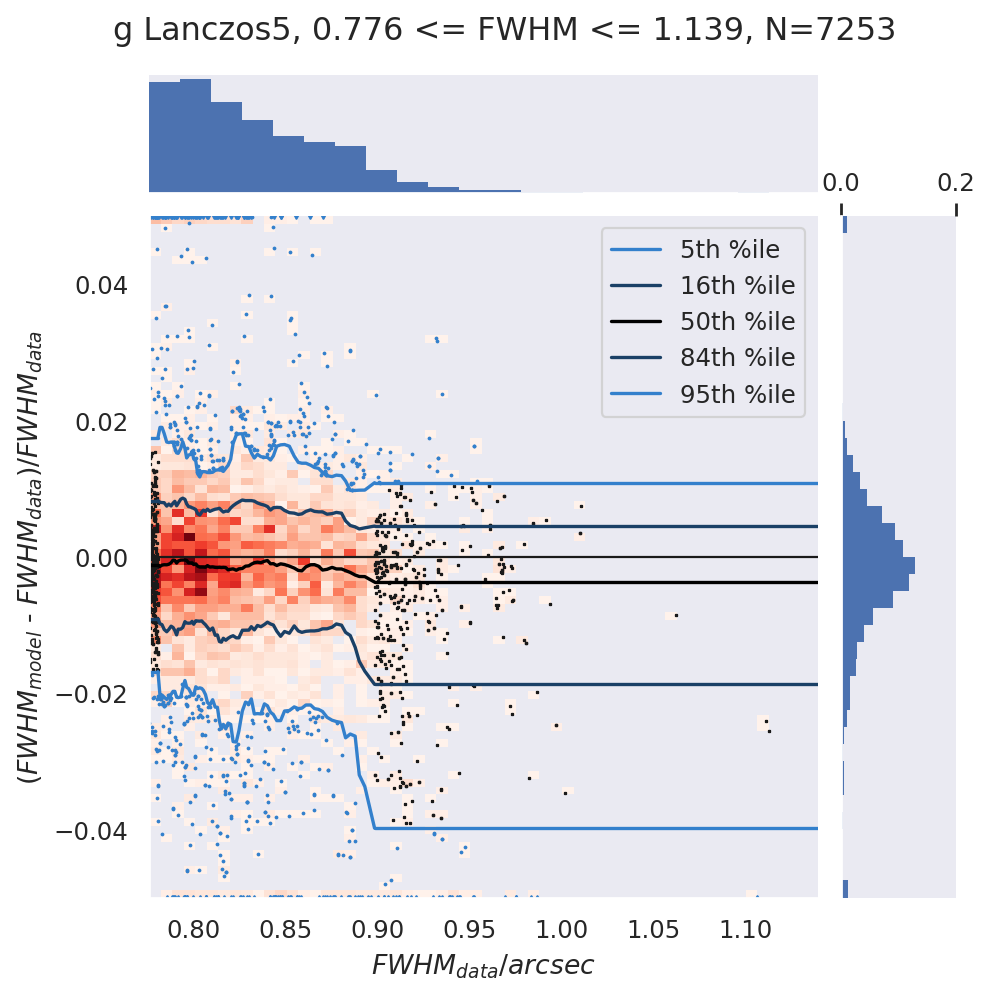

r Lanczos5, 0.392 <= FWHM <= 0.475, N=10557


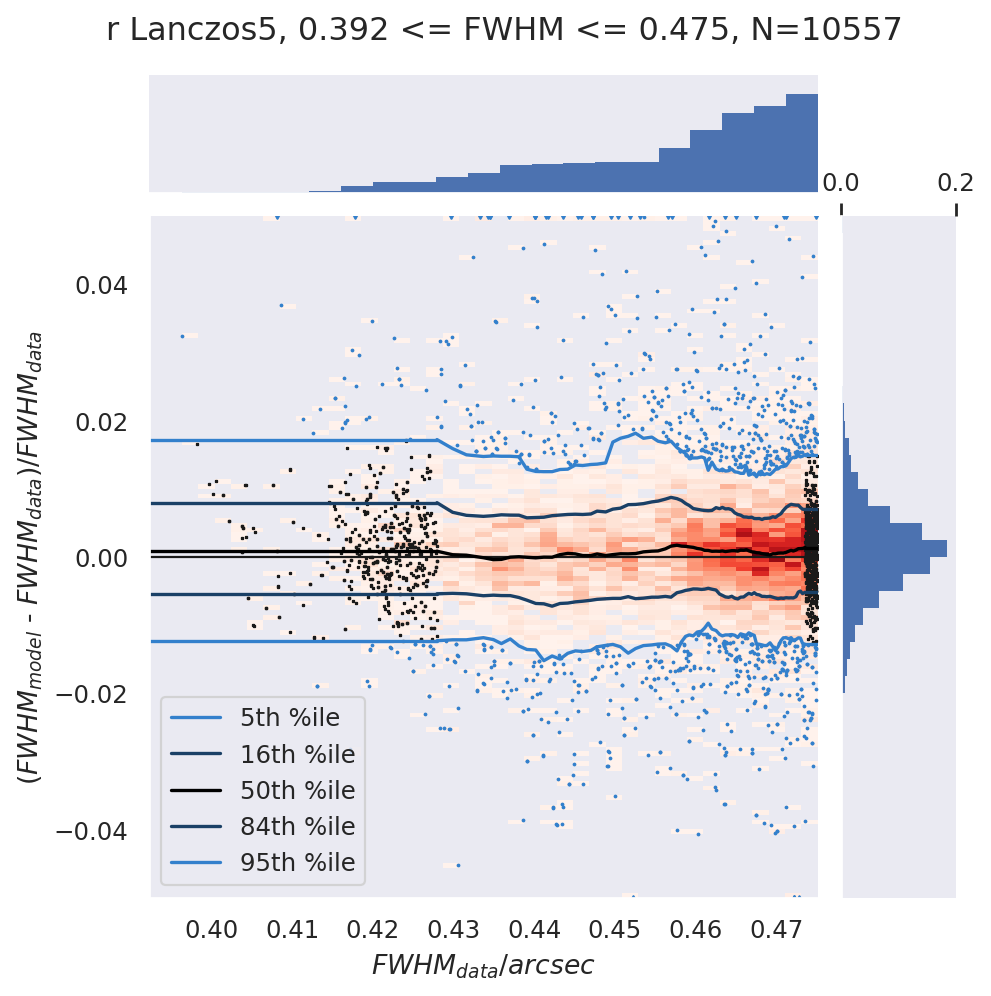

r Lanczos5, 0.475 <= FWHM <= 0.498, N=10557


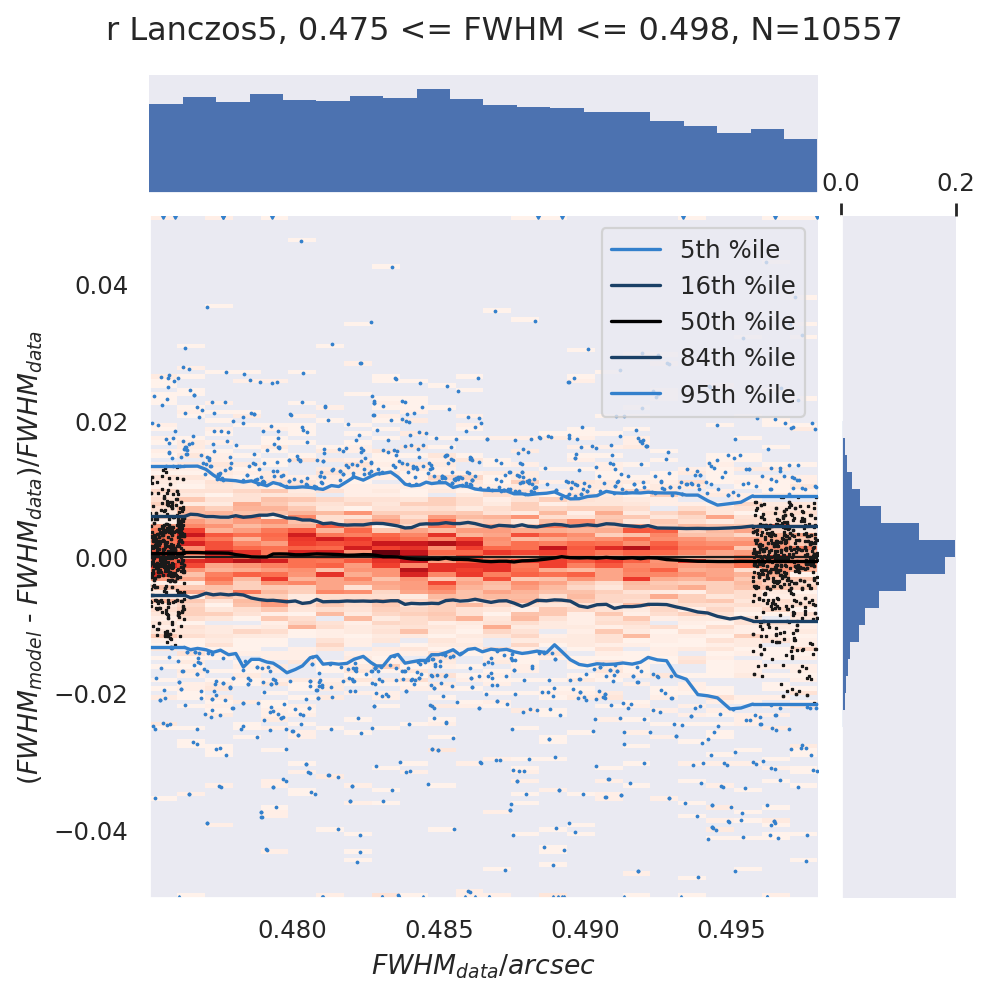

r Lanczos5, 0.498 <= FWHM <= 0.592, N=10557


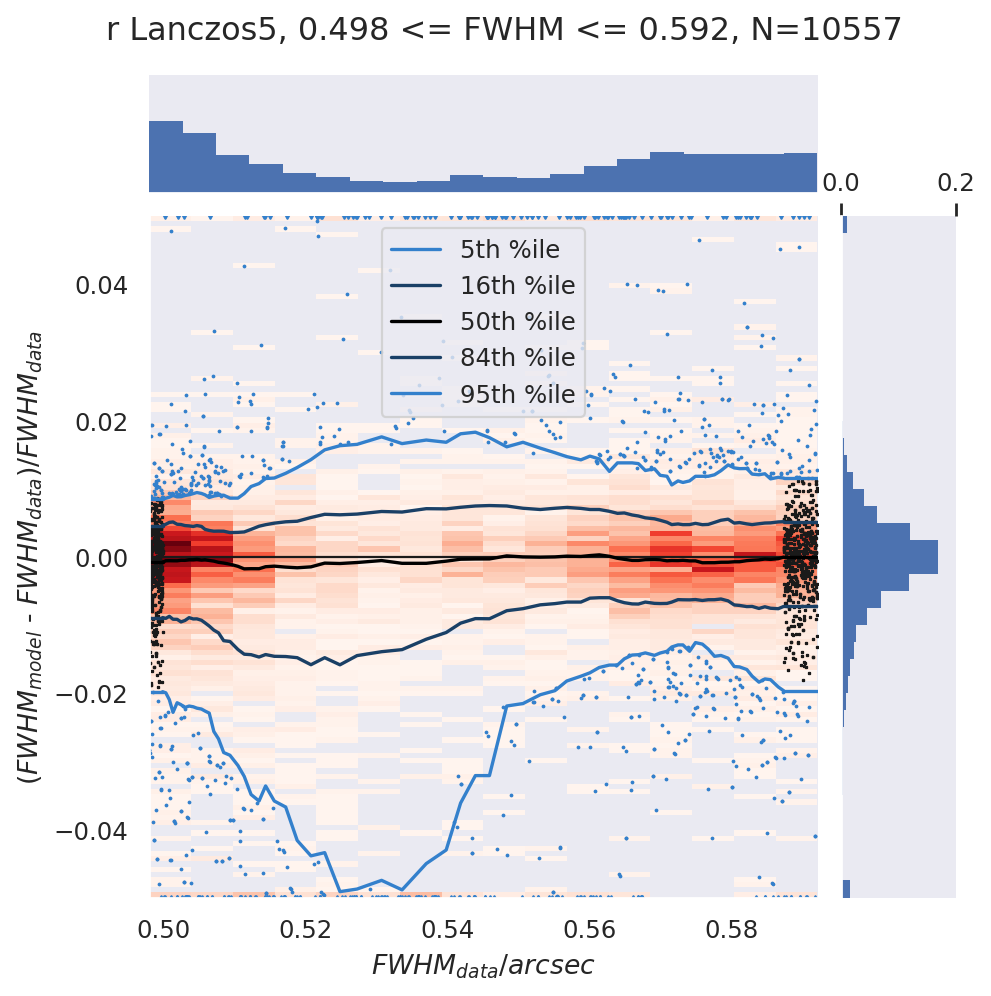

r Lanczos5, 0.592 <= FWHM <= 0.881, N=10557


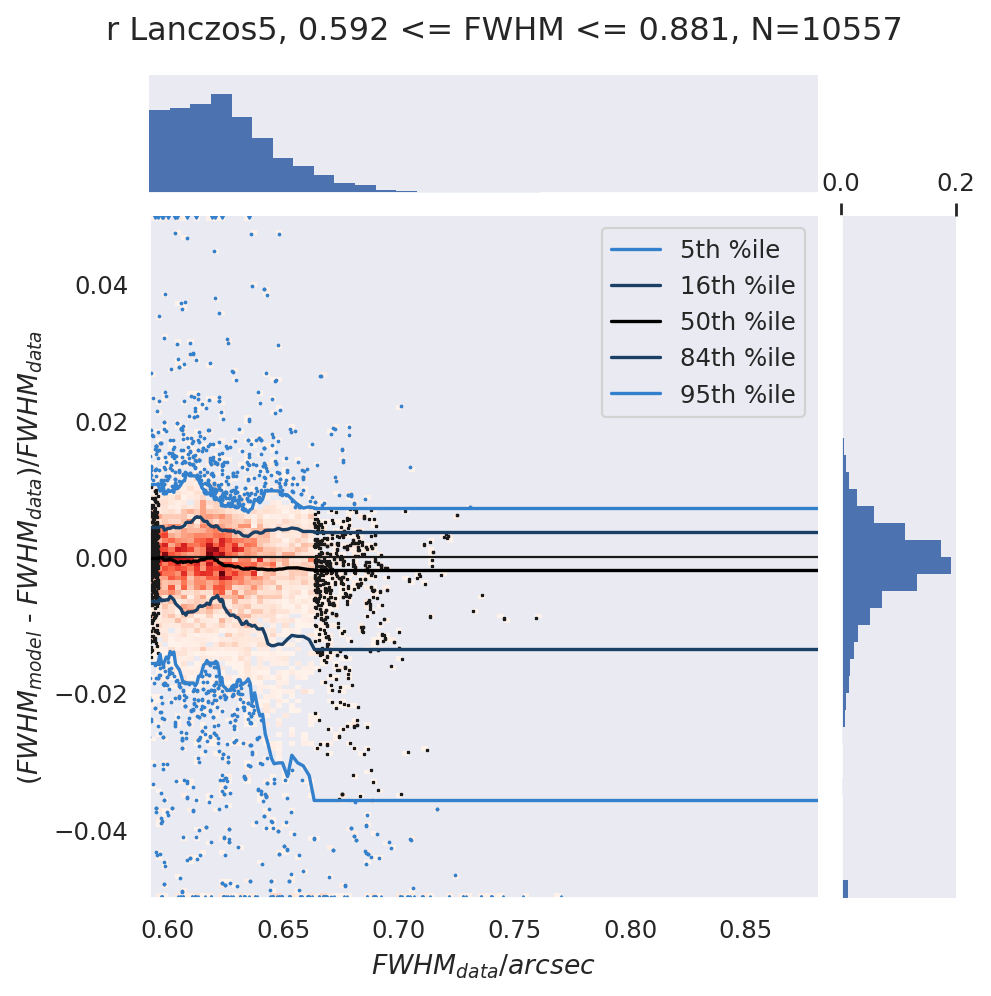

i Lanczos5, 0.412 <= FWHM <= 0.468, N=9282


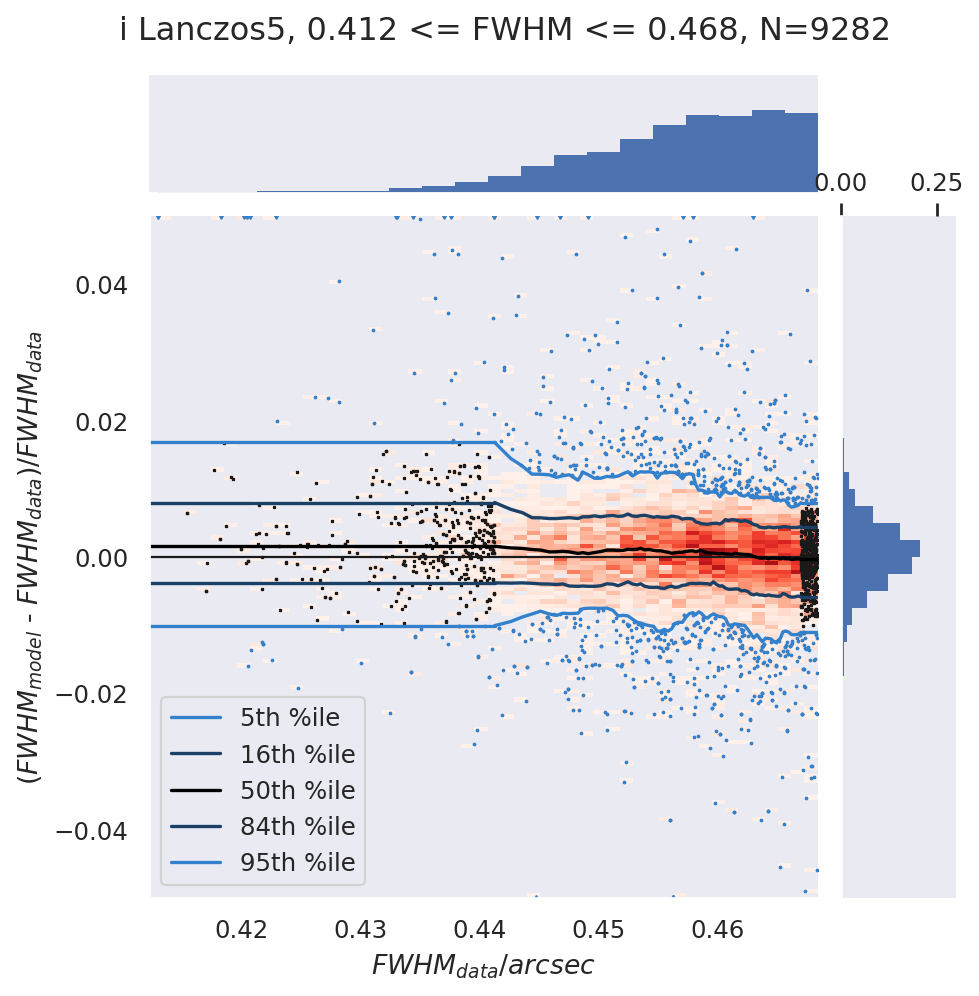

i Lanczos5, 0.468 <= FWHM <= 0.502, N=9282


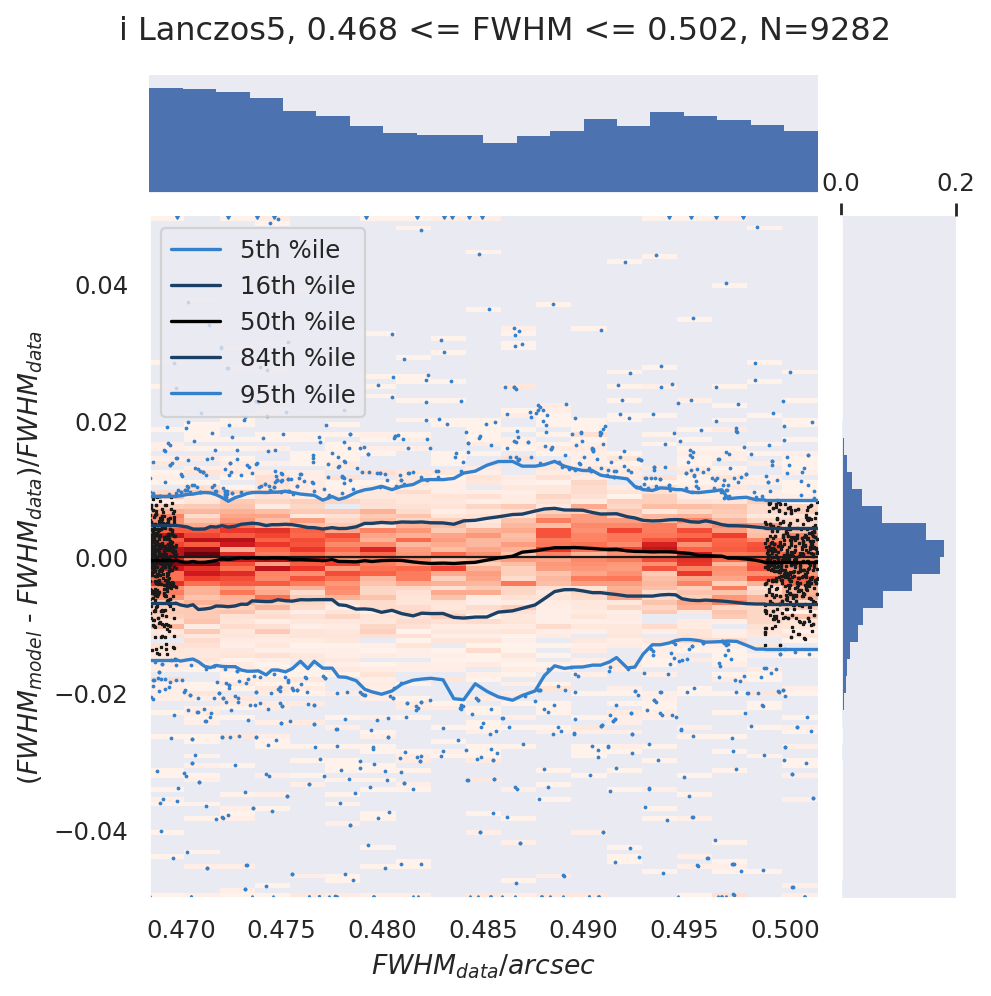

i Lanczos5, 0.502 <= FWHM <= 0.540, N=9283


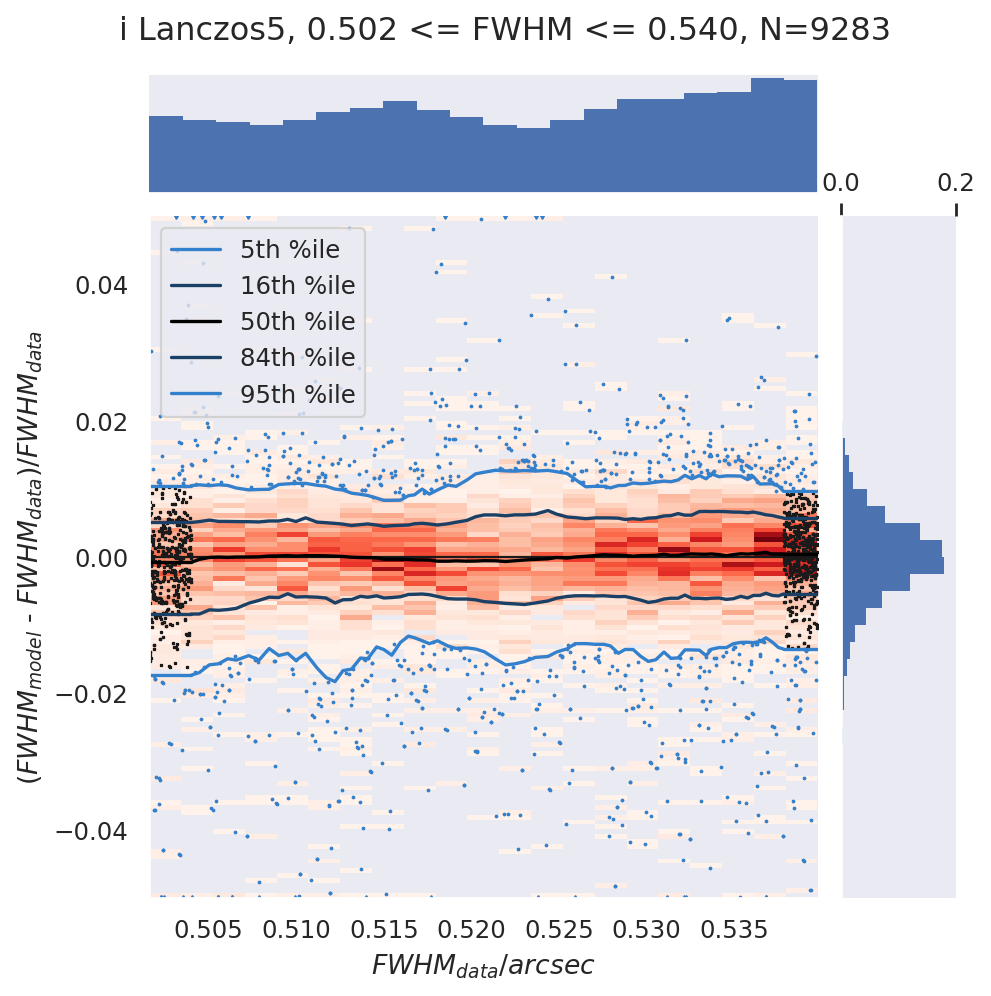

i Lanczos5, 0.540 <= FWHM <= 0.700, N=9282


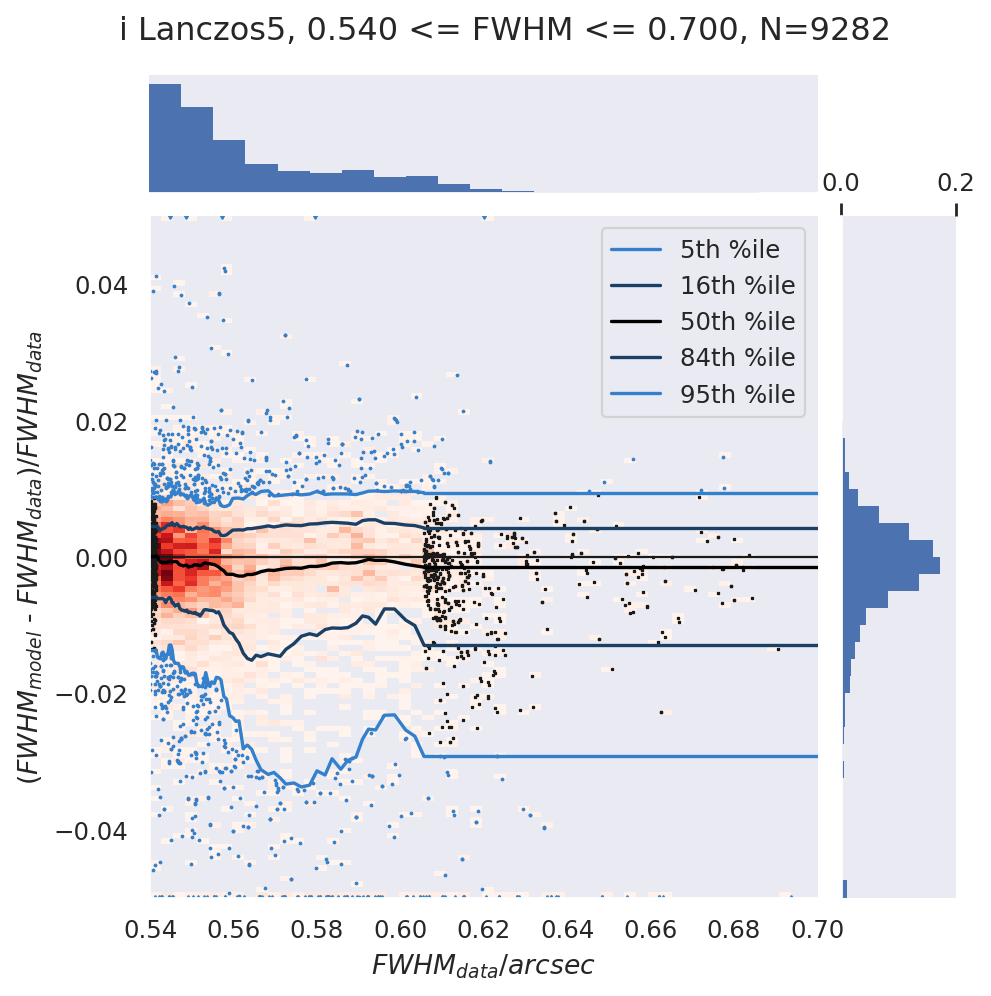

In [8]:
# Plot
kwargs_plotjoint = dict(
    nbinspan = 8,
    densityplot=sns.histplot,
    cmap='Reds',
    limy=limsfrac,
    scatterleft=True,
    scatterright=True,
)
plot_patch = False
labelflux = 'log10(instFluxPsf)'
labelsizeresid = r'($FWHM_{model}$ - $FWHM_{data}$)/$FWHM_{data}$'
labelsize = r'$FWHM_{data}/arcsec$'

for dataplot, typeofdata in ((data, 'Lanczos5'),):
    for band, limx in limxs.items():
        datum = dataplot[band]
        limx = limxs[band]
        x = np.clip(datum['starSize'], limx[0], limx[1])
        sizefrac = (datum['modelSize'] - datum['starSize'])/datum['starSize']
        title=f'{band} {typeofdata} PSF model residuals (N={len(x)})'
        print(title)
        plotjoint_running_percentiles(
            x, sizefrac, limx=limx, ndivisions=32,
            labelx=labelsize, labely=labelsizeresid, title=title,
            **kwargs_plotjoint
        )
        plt.show()
        
for dataplot, typeofdata in ((data, 'Lanczos5'),):
    for band, limx in limxs.items():
        datum = dataplot[band]
        sizefrac = (datum['modelSize'] - datum['starSize'])/datum['starSize']
        condsizefrac = np.isfinite(sizefrac) & np.isfinite(datum['fluxPsf']) & (datum['starSize']<2)
        sizebins = np.sort(datum['starSize'][condsizefrac])[
            np.asarray(np.round(np.linspace(0, np.sum(condsizefrac)-1, num=4+1)), dtype=int)
        ]
        for idx in range(len(sizebins) - 1):
            sizemin, sizemax = sizebins[idx:idx+2]
            cond = condsizefrac & (datum['starSize'] > sizemin) & (datum['starSize'] < sizemax)
            numpoints = np.sum(cond)
            title = f'{band} {typeofdata}, {sizemin:.3f} <= FWHM <= {sizemax:.3f}, N={numpoints}'
            if numpoints >= 100:    
                print(title)
                x = datum['starSize'][cond]
                y = sizefrac[cond]
                plotjoint_running_percentiles(
                    x, y, limx=(sizemin, sizemax), ndivisions=10,
                    labelx=labelsize, labely=labelsizeresid, title=title,
                    **kwargs_plotjoint
                )
                plt.show()
        if plot_patch:
            # TODO: Make sensible plots per patch
            for patch in patches:
                cond = (datum['file'] == patch) & condsizefrac
                grid = sns.jointplot(
                    np.log10(datum['fluxPsf'][cond]), sizefrac[cond], ylim=[-0.1, 0.1],
                    stat_func=None, size=4, s=1, marginal_kws={'bins': 30},
                )
                grid.fig.suptitle(band)